# Determining Ideal Wind Farm Size

#### Final project for Geography 136 taught by Professor Caylor at the University of California Santa Barbara 

Project By Jack Holbrook

<img src="./myassets/title.PNG" alt="prac1" width="800"/>

In the future, renewable energy sources will need to become the dominant source of electricity generation in order to curb the effects of climate change Wind Energy is a mean by which people can renewably generate power in the future. A current limitation with wind energy is that it has very low power density compared to other forms of energy generation. Power density in this project is expressed as Watts per square meter. In this project, I will attempt to identify what attributes of wind turbines are correlated with a wind power project's power density. The four independent variables I look at in particular are:

The area of the wind project in square meters
The rotor diameter of each turbine
The number of turbines located in each project
The capacity in MW of each project. 

Two seperate multiple linear regressions will be run to give coefficients for each independent variable that affects the power density for wind projects. Lastly, a calculation using an objective function will be used to calculate the maximum power density possible for an imaginary wind power plant that uses constraints and weights based off coefficients derived from the relationship between power density and the independent variables. 

### Looooading in The Data!

The first order of business is to load in the correct USWTDB data. 
options: excel sheet which is on a per project level, or large sheet which is on a per turbine level. 
The latter of the two may not be able to to found on box, but can be found as a .shp which could be coverted to a .csv and loaded into a folder along with the .csv of the per project data so both can be used in this .ipynb. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

I will use additional packages later, but until then these are the first three packages that will be used in this project. 

The metadata on the original point layer can be found here:
    
    https://eerscmap.usgs.gov/uswtdb/assets/data/uswtdb_v3_0_1_20200514.xml

In [4]:
windProjects = pd.read_csv('../data/final_project/USWTDB_perproject.csv')

Here Is what the Dataframe looked like in Excel:

<img src="./myassets/Screenshot (254).png"  width="400"/>

In [5]:
USWTDB = pd.read_csv('../data/final_project/USWTDB_Turbine_t_rd.csv')

Here Is what the Dataframe looked like in Excel:

<img src="./myassets/Screenshot (255).png"  width="400"/>

 <li> 📌 Getting Ready! </li>
The first thing to do is to get familiar with the data that will be used to find an optimal wind power plant size. Some easy first steps include identifying the names of the data's feature, the shape of each dataframe, and identifying the data types found in each of the data frames.

In [68]:
# this is just for visualizing the data that we will be working with. I will do comparitive statistics 
# and multiple linear regressions on the different datas in this in order to produce helpful statistics 
# for the project.  

print(windProjects.columns) 
print(USWTDB.columns)

Index(['p_name', 'p_tnum', 'p_cap_MW', 'p_cap_kW', 'mean_t_cap_kW',
       'mean_t_rd', 'mean_t_hh', 'area_m2', 'power_density_Wm2',
       'Configuration'],
      dtype='object')
Index(['p_name', 'p_tnum', 'p_cap_MW', 't_cap_kW', 't_hh', 't_rd'], dtype='object')


In [69]:
# This dataset has many features on each project, each project has from one to hundreds of turbines
print(windProjects.shape)

# This dataset has a few features, but includes every single turbine that is part of a project containe in df windProjects
print(USWTDB.shape)

(88, 10)
(5958, 6)


In [8]:
# This dataframe has two columns that use strings, they can be assigned numbers in order to be used in statistics. 
print(windProjects.head())

# some Nans are visible at the head. Here they are represented by '-9999', .groupby will be used to clear out Nan values.
print(USWTDB.head())

            p_name  p_tnum  p_cap_MW  p_cap_kW  mean_t_cap_kW  mean_t_rd  \
0         251 Wind     188    16.055     16055           95.0     30.287   
1  Alite Wind Farm       8     8.000      8000         3000.0     90.000   
2           Alta I     100   100.000    100000         1500.0     77.000   
3          Alta II      41    50.000     50000         3000.0     90.000   
4         Alta III      50    50.000     50000         3000.0     90.000   

   mean_t_hh      area_m2  power_density_Wm2 Configuration  
0        NaN   2433131.85           6.598492           NaN  
1       80.0   3459998.53           2.312140           NaN  
2       80.0  23518405.61           4.251989           NaN  
3       80.0  15097866.66           3.311726           NaN  
4       80.0  15359516.92           3.255311           NaN  
     p_name  p_tnum  p_cap_MW  t_cap_kW    t_hh    t_rd
0  251 Wind     169    16.055        95 -9999.0 -9999.0
1  251 Wind     169    16.055        95 -9999.0 -9999.0
2  251 Wi

### Great! We are familiar with the basics of the data.

<li> 📌 Seeing how this data is related </li>
The wind turbine data in the windProjects dataframe has been aggregated by the name of each wind farm, this feature is named 'p_name' in each dataframe as it stands for "project name". 

The relationship between the two datasets can be seen through this feature, infact, the USWTDB can easily take on a similar shape to the windProjects dataframe by grouping its values by project name!

In [71]:
####
# Quick sanity check!
####

print(windProjects['p_name'].value_counts)
print(len(USWTDB['p_name'].unique())) 
# this is to make sure that there is exists the same amount of projects for each .csv.

# You can even check this by printing out a groupby object. 
USWTDB.groupby('p_name').sum()

<bound method IndexOpsMixin.value_counts of 0                251 Wind
1         Alite Wind Farm
2                  Alta I
3                 Alta II
4                Alta III
             ...         
83        Whitewater Hill
84               Windland
85    Windridge Wind Farm
86               Windstar
87            Wintec Palm
Name: p_name, Length: 88, dtype: object>
88


,p_tnum,p_cap_MW,t_cap_kW,t_hh,t_rd
p_name,,,,,
251 Wind,32372,3075.34,17860,-1879812.0,-1879812.0
Alite Wind Farm,64,192.00,24000,640.0,720.0
Alta I,10000,15000.00,150000,8000.0,7700.0
Alta II,2050,6150.00,123000,3280.0,3690.0
Alta III,2500,7500.00,150000,4000.0,4500.0
...,...,...,...,...,...
Whitewater Hill,1681,2521.50,61500,2665.0,2665.0
Windland,3368,785.52,16440,-579782.0,-479576.4
Windridge Wind Farm,1681,168.10,3690,-409959.0,-409959.0


### Plotting Data as Part of EDA

In order to do exciting things such as determining if rotor diameter affects power density, first the user should plot the data in its natural state to see what shape its values make it take. Below, matplot lib pyplot plots were created to do just that. they help the user understand the nature of the data. these preliminary visualizations are from the smaller "windProjects" dataframe. This means that 88 points are in each subplot. It will also be important to get a line of best fit for each dataset. A linear line of best fit will follow the equation:
                                            
                                            Y = Mx + B
                                            
numpy can be used to create a line of best fit from data on a subplot. Below a line of best fit is drawn from the code:

                    plot(np.unique(y1), np.poly1d(np.polyfit(y1, X, 1))(np.unique(y1))
                    
plot( np.unique( y ), begins this line of code with the plot command. These is a varibale before th e.plot to indicate where this is plotting from. In the first argument of plot, np.unique selects unique values of the array in the unique argument.

..., np.poly1d(np.polyfit(y, x, 1))... poly1d is a one dimensional polynomial class, meaning it is also in an array shape. 
inside this array's argument is np.polyfit() which is used to return a line of best fit that follows a linear equaiton that minimises the least squared error. the x and y inside the np.polyfit() argument are variabels that represent the data thats being plotted. The interger in the third part of the argument is the degree of the polynomial. By increaseing this interger, the line will curve to become closer to the center of the plotted data as it travels along the x axis. 

...(np.unique( y )) will end this line of code by being in its own level of indentation, this also take unique values of the variable it holds, it is there to give the array that affects the slope of the line. 


<bound method Axes.set_ylabel of <matplotlib.axes._subplots.AxesSubplot object at 0x7f0d1b7e7550>>

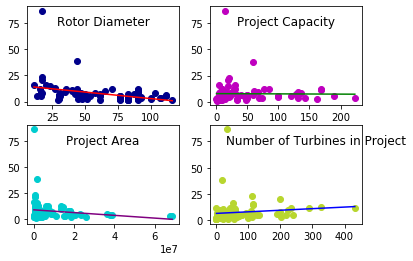

In [170]:
####
# Using matplot lib.
####

# Assign variable to each of the four features that will be plotted against power density
X = windProjects.power_density_Wm2
y1 = windProjects.mean_t_rd
y2 = windProjects.p_cap_MW
y3 = windProjects.area_m2
y4 = windProjects.p_tnum

# Initialize figure and add subplots
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# plot each set of records, include line of best fit for each. 
ax1.scatter(y1, X, color='darkblue')
ax1.plot(np.unique(y1), np.poly1d(np.polyfit(y1, X, 1))(np.unique(y1)), color = 'red')
ax1.set_title('Rotor Diameter', y=.75)
ax1.set_xlabel
ax1.set_ylabel

ax2.scatter(y2, X, color='m')
ax2.plot(np.unique(y2), np.poly1d(np.polyfit(y2, X, 1))(np.unique(y2)), color = 'green')
ax2.set_title('Project Capacity', y=.75)
ax2.set_xlabel
ax2.set_ylabel

ax3.scatter(y3, X, color=(0.0,0.8,0.81))
ax3.plot(np.unique(y3), np.poly1d(np.polyfit(y3, X, 1))(np.unique(y3)), color = 'purple')
ax3.set_title('Project Area', y=.75)
ax3.set_xlabel
ax3.set_ylabel

ax4.scatter(y4, X, color='#B8D62E')
ax4.plot(np.unique(y4), np.poly1d(np.polyfit(y4, X, 1))(np.unique(y4)), color = 'blue')
ax4.set_title('Number of Turbines in Project', x=.7, y=.75)
ax4.set_xlabel
ax4.set_ylabel

We Succesesfully determined the slope for each of these plots, but they seem to be affected by outliers. We will use a box plot to identify the affect this outlier has on the data in the windProjects dataframe.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0d1e1bf5d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0d1e1c8c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0d1e1bf590>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0d1e1ce690>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0d1e1ceb90>],
 'means': []}

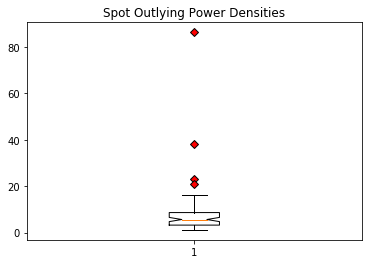

In [64]:
####
# Box plot used to identify outliers. 
####

green_diamond = dict(markerfacecolor='r', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Spot Outlying Power Densities')
ax1.boxplot(X, flierprops= green_diamond, notch = True)

#### Wow! those are some big outliers!
Below, this is the largest outlier in the data shown on arcGIS. Both projects shown have high power densities. The purple one is the highest at 86.34 Wm2. The wind farm in the green buffer has the 3rd highest power density at 22.97 Wm2. These values are borderline ridiculous in the context of wind power and warrant their own investigation some other time.


<img src="./myassets/outlier.PNG"  width="600"/>

Now that It is known that there are outliers in the data, these can be cut out in order to improve the correlation between power density and the independent variables.  

In [72]:
####
# Using our new knowledge to create a filtered dataset.
####

windProjects_clean = windProjects[(windProjects['power_density_Wm2'] < 20)]

# 16 W/m2 is a much more reasonalbel outlier than 80 is!
windProjects_clean.power_density_Wm2.max()
# yields 16.22692153 Wm2

16.22692153

The lines that were made earlier are very useful for visualizing, but they don't give us the slope! We can write a function to find the slope of a linear line, m. We can call this function for each case where the slope of a line of best fit between two arrays needs to be found. Since we don't want the calculated slope to be affected by outliers, we will use a new values for X from the filtered dataset. This means the slope generated will be different from the slopes of the best fit lines that were created earlier.

<img src="./myassets/firstplots.PNG"  width="600"/>

To begin with, a function will be created to calcuated the slope from the data in windProjects_clean.

In [41]:
from statistics import mean

def best_fit_slope(X,y):
    m = (((mean(X)*mean(y)) - mean(X*y)) /
         ((mean(X)**2) - mean(X**2)))
    return m

In [73]:
####
# Showing the outputs of each line of best fit's slope. 
####

#Create new varibales that relate tot he filtered dataset instead of the unfiltered one.  
Xf = windProjects_clean.power_density_Wm2
y1f = windProjects_clean.mean_t_rd
y2f = windProjects_clean.p_cap_MW
y3f = windProjects_clean.area_m2
y4f = windProjects_clean.p_tnum

#Rotor Diameter to Power Density
print(best_fit_slope(Xf,y1f))
# -3.4992544993132397

#Project Capacity to Power Density
print(best_fit_slope(Xf,y2f))
# 1.6945113296937755

#Project Area to Power Density
print(best_fit_slope(Xf,y3f))
# -689602.4133326128

#Number of Turbines in Project to Power Density
print(best_fit_slope(Xf,y4f))
# 9.302683353295956

-3.4992544993132397
1.6945113296937755
-689602.4133326128
9.302683353295956


### Analysis On A Per Turbine Level

<li> 📌 THE USWTDB dataset </li>

Shifting focus to the USWTDB DataFrame, this dataframe also has Nan values, some of which obstruct from plotting key records straight out of the box. Let's count the number of records that aren't Nans for each. 

In [73]:
####
# More EDA: see if the p_cap_MW, p_tnum are completely full!
####

print(sum(USWTDB.p_cap_MW > 0))  # Missing one record, 5957 
print(sum(USWTDB.p_tnum > 0))    # Is full, 5958
print(sum(USWTDB.t_cap_kW > 0))  # 4872
print(sum(USWTDB.t_hh > 0))      # 3100, most sparse data
print(sum(USWTDB.t_rd > 0))      # 3967

5957
5958
4872
3100
3967


In [21]:
####
# Create new objects for all the turbines that will have no Nan or '-9999' values.
####

# The first willbe specifically for t_rd since this is an important measurement in the analysis 
WTDB_rd = USWTDB[(USWTDB['t_cap_kW'] > 0) & (USWTDB['t_rd'] > 0)]

# The second will be a df with no Nan or '-9999' values at all.
WTDB_small = USWTDB[(USWTDB['t_cap_kW'] > 0) & (USWTDB['t_hh'] > 0) & (USWTDB['t_rd'] > 0)]

#USWTDB, WTDB_rd and WTDB_small will each give the interpreter different statistics, but the large data set is still helpful. 
print(WTDB_small.mean())
print(WTDB_small.shape)
print(WTDB_rd.mean())
print(WTDB_rd.shape)

p_tnum       149.712258
p_cap_MW      85.324008
t_cap_kW    1302.930645
t_hh          56.744226
t_rd          60.523968
dtype: float64
(3100, 6)
p_tnum       149.793547
p_cap_MW      69.531933
t_cap_kW    1039.062264
t_hh       -2140.969473
t_rd          51.030678
dtype: float64
(3967, 6)


So, we've created seperate Dataframes for the data that we want to be able to plot! 

Next, the data on a per turbine level will be plotted the goal of this is to make sure that characteristics of the turbines are correlated with one another on a per unit level. If there appears to be correlation on a per project lvel, but not at a per unit level, this would be problematic becuase it would suggest a false correlation between attributes of wind turbines and they amount of electricity they genrate per unit area. 

Text(0, 0.5, 'p_cap_MW')

<Figure size 432x288 with 0 Axes>

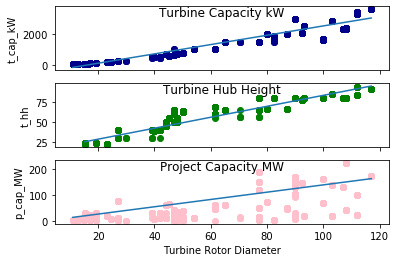

In [50]:
####
# Plotting the USWTDB data
####

fig = plt.figure()

#plotting t_rd v.s.t_hh, t_cap_kW, and p_cap_MW

X = WTDB_rd['t_rd']
X_ = WTDB_small['t_rd']

y1 = WTDB_rd['t_cap_kW']
y2 = WTDB_small['t_hh']
y3 = WTDB_rd['p_cap_MW']

# Add three subplots
fig, axs = plt.subplots(3, sharex=True, sharey=False)

axs[0].scatter(X, y1, color='darkblue')
axs[0].plot(np.unique(X), np.poly1d(np.polyfit(X, y1, 1))(np.unique(X)))
axs[0].set_title('Turbine Capacity kW', y=.75)
axs[0].set_ylabel('t_cap_kW')

axs[1].scatter(X_, y2, color='green')
axs[1].plot(np.unique(X_), np.poly1d(np.polyfit(X_, y2, 1))(np.unique(X_)))
axs[1].set_title('Turbine Hub Height', y=.75)
axs[1].set_ylabel('t_hh')

axs[2].scatter(X, y3, color='pink')
axs[2].plot(np.unique(X), np.poly1d(np.polyfit(X, y3, 1))(np.unique(X)))
axs[2].set_title('Project Capacity MW', y=.75)
axs[2].set_xlabel('Turbine Rotor Diameter')
axs[2].set_ylabel('p_cap_MW')

Great! We've plotted the four varibales we want to regress by on the per project level, and the three variable we want to regress by on the level of the individual turbines. 

However, We are not sure how well these lines represent actual relationships in the data, we need to determine correlation. this can be done with a ready-made function from the scipy library. 

In [56]:
####
# Using scipy.stat's linear regression function to find bivariate regression
####

import scipy
from scipy import stats

print(scipy.stats.linregress(X, y1))
# slope= 30.249063537530326, intercept= -504.56796036174455, 
# rvalue= 0.941300184383509, pvalue= 0.0, stderr= 0.17227684551306416

print(scipy.stats.linregress(X_, y2))
# slope= 0.6850783763112469, intercept=15.280564257892173, 
# rvalue= 0.9620659234242565, pvalue= 0.0, stderr= 0.003490328285352953

print(scipy.stats.linregress(X, y3))
# slope= 1.3990765599391428, intercept= -1.8638921085334488, 
# rvalue= 0.792034569496316, pvalue= 0.0, stderr= 0.017125549428549006)

LinregressResult(slope=30.249063537530326, intercept=-504.56796036174455, rvalue=0.941300184383509, pvalue=0.0, stderr=0.17227684551306416)
LinregressResult(slope=0.6850783763112469, intercept=15.280564257892173, rvalue=0.9620659234242565, pvalue=0.0, stderr=0.003490328285352953)
LinregressResult(slope=1.3990765599391428, intercept=-1.8638921085334488, rvalue=0.792034569496316, pvalue=0.0, stderr=0.017125549428549006)


the value R, Pearson's correlation Coefficient, is helpful, but It is also important tot know the determination coefficient:
R^2. 

We can find the r^2 values from these outputs simply by taking the r values from each, then squaring them. 
The P values here  are zero becuase the null hypothesis is rejected when a correlation is determined in data. The null hypothesis states that data has no correlation, however, if correlation is found, then the null hypothesis can be rejected. the P value apporaches zero as the certainty that the data is correlated increases. 

an example of uncorrelated data would be if I used math.random() without parameters to make a completely random dataset. 

<img src="./myassets/random.jpg"  width="600"/>

The r values from the three previous regressions are initialized in a list and r^2 values are computed from them below. 

In [163]:
####
# Finding R^2 values (Coefficients of determination) from USWTDB linear regressions
####

r_vals = [0.941300184383509, 0.9620659234242565, 0.792034569496316]
for r in r_vals:
    rsq = r*r
    print(rsq)

0.8860460371204281
0.9255708410141673
0.6273187592772146


<li> 📌 We R serious </li>

R^2 values of 0.8 or higher typically indicate a trned. There are two values that are greater than 0.8. The one value that isn't greater than 0.8 is the correlation between turbine rotor diameter and the capacity of each turbine project, this makes sense beucase multilpe factors lpay into a wind project's overall capacity. However, one concerning part about this being the weakest correlation is that a correlation between these needs to be assumed in order for rotor diameter to correlate with power density.

### Running multiple Linear Regressions



We need the necessary Imports in order to run multiple linear regressions on the data. 

 ▶️ <b> Import statsmodels </b>

In [74]:
from sklearn import linear_model
import statsmodels.api as sm

The regression will take two inputs, X and y. X will be assigned to the independent variables while y will the the dependent variable, power density. 

Two seperate linear regressions were done. one regression was with the independent variables as the mean rotor diameter per project, the number of turbines per project, and the project capacity. The other regression only had two indendent variables which were the mean rotor diameter and the square area of each project. These regressions were run seperatly becuase since the values of area are in square meters, each value in this independent variable is huge compared to the values of other variables. the coefficients output from the regression change drastically when they are regressed along with the area in square meters. This also allows for a distinction between an explicitly spatial regression that has units of area in the independent and dependent variables versus a regression where only the dependent variable contain units of area. 

In [81]:
####
# Multiple Linear Regression
####

X1 = windProjects_clean[['mean_t_rd', 'p_tnum', 'p_cap_MW', ]]
X2 = windProjects_clean[['mean_t_rd', 'area_m2' ]]
y = windProjects_clean['power_density_Wm2']

##############################################################

# With sklearn
windProjects_rgr1 = linear_model.LinearRegression()
windProjects_rgr1.fit(X, y)

# Printing values from the multiple linear regression
print('Intercept: \n', windProjects_rgr1.intercept_)
print('Coefficients: \n', windProjects_rgr1.coef_)

##############################################################

# This is a two variable regression that uses area
windProjects_rgr2 = linear_model.LinearRegression()
windProjects_rgr2.fit(X2, y)

# Printing values from the multiple linear regression
print('Intercept: \n', windProjects_rgr2.intercept_)
print('Coefficients: \n', windProjects_rgr2.coef_)

Intercept: 
 9.780123381910588
Coefficients: 
 [-0.08336018  0.00227602  0.0313557 ]
Intercept: 
 9.792615803019565
Coefficients: 
 [-6.26453534e-02  2.37111873e-08]


#### Results:

Intercept: 
 9.780123381910588
Coefficients: 
 [-0.08336018     0.00227602     0.0313557 ]
 
 Order: Rotor Diameter, Number of Turbines, Project Capacity in MegaWatts. 

Intercept: 
 9.792615803019565
Coefficients: 
 [-6.26453534e-02     2.37111873e-08]
 
 Order: Rotor Diameter, Area in square meters.

#### Takeaway from Coefficients:
<li> 📌 What can be understood from these values? </li>


It should make sense that the coefficients in both multiple linear regressions should be small since the range of values for power density are about 20 while the range of values for rotor diameter is about 100 and the range of values for the number of turbines per project and project capacity in MegaWatts are both in the hundreds.

The multiple regression using area and rotor diameter worked similar to this, since the values of area are given in square meters, it takes thousands of square meters to change a power density in a wind farm by a single Watt per square meter. 

## Optimizing Power Density Using Linear Programming

Linear programming is a method that is used to linearly locate an optimal value based upon a set of variables and constraints.
We will be using two variables identified from the windProjects_clean dataframe, the inverse of the slope of area to power density, the inverse of the slope of turbine projects to power density, and the coefficient of project capacity from the sklearn multiple variable linear regression.

Linear programming is used as a method for isolating a single point on an imaginary convex hull, convex points of the hulls, called feasible region, are considered points of optimality becuase they represent the maximum of two limits that are expressed as lines.

<img src="./myassets/convex.PNG"  size="600 * 200"/>

The inverse of slopes from the windProject_clean dataframes are used becuase the goal is to have the variabels associated with them represent a single unit of change in either area (units m2) or amount of turbines (1 turbine).

The goal is to create an objective function to optimize the power density of an imaginary wind turbine project. 

In [94]:
!pip install pulp
import pulp

     |████████████████████████████████| 40.6MB 79.5MB/s eta 0:00:01


### The Pulp Library:
<li> 📌 Linear optimization </li>


The pulp library provides a human friendly way to create and solve an objective function.

The way the library works is an optimization problem has to be initialized and variables are assigned to it. After the objective function is is created ( this is optimalPD in the code below), constraints are added to it. 

objfxn.solve() will solve the objective function, it is written this way becuase linear programming problems can be robust sometimes. Lastly, the answer is printed out. 

In [164]:
####
# Using Pulp Library to creeate an objective function
####

# Initialize the problem
optimalPD = pulp.LpProblem("Linear Optimization for Wind Turbine Power Density", pulp.LpMaximize)

# Assign variables to weights in objective function
x = pulp.LpVariable('x', lowBound=0, cat='Continuous')
y = pulp.LpVariable('y', lowBound=0, cat='Continuous')
w = pulp.LpVariable('w', lowBound=0, cat='Continuous')


# Objective function
optimalPD += -0.00000145011 * x +  0.110739 * y +  0.0313557 * w  , "Z"

#  Add Constraints
optimalPD += y <= 200 # we can't have more than 200 turbines!

optimalPD += w >= 100 # minimum capacity of 200 MW

# Solve problem
optimalPD.solve()

# Print Solution
print(pulp.value(optimalPD.objective))
# objective value gets printed

25.28337


## Are These Realistic Wind Power Density values?

The methods used in the process of obtaining the area for each wind project in this exercise were not ideal for calcualting realistic wind power densities, in reality wind power densities are lower than the values seen in this project. This is becuase the methods that were used to calcualte the area occupied by each wind project undercounted the area the projects occupy in reality. Buffer edges were dissolved in the arcGIS calculation of the area which led to smaller values of area, when these were used to divide the capacities of each project, they resulted in higher power densities. 

<img src="./myassets/wind.jpg"  width="600"/>

# References:


Multiple Linear Regression:
https://datatofish.com/multiple-linear-regression-python/

Creating lines of Best Fit for MatPlot Lib:
https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python

Box:
https://matplotlib.org/3.2.1/gallery/pyplots/boxplot_demo_pyplot.html

Pulp: 
https://benalexkeen.com/linear-programming-with-python-and-pulp-part-2/